# **Tweeter Sentiment Analysis**

# Business Understanding

Companies need to understand public sentiment about their products on social media to make informed marketing, product development, and customer service decisions. So for this analysis we are going provide insights into public perception of Google versus Apple products through sentiment.




# Data Understanding

In [ ]:
!pip install lime --quiet

In [ ]:
# Core Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
import os
# Text Processing Libraries
import re
import nltk
import string
from nltk import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline  # Important for model pipelines
from sklearn.preprocessing import LabelEncoder
# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Model Interpretability (LIME)
import lime
from lime.lime_text import LimeTextExplainer

# Additional utilities
from collections import Counter
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
print("Downloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
!wget https://raw.githubusercontent.com/dbvimpec/Tweeter_Sentiment_Analysis/main/tweets.csv

--2025-09-03 03:32:01--  https://raw.githubusercontent.com/dbvimpec/Tweeter_Sentiment_Analysis/main/tweets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1260464 (1.2M) [application/octet-stream]
Saving to: ‘tweets.csv’

tweets.csv          100%[===================>]   1.20M  --.-KB/s    in 0.06s   

2025-09-03 03:32:01 (18.5 MB/s) - ‘tweets.csv’ saved [1260464/1260464]



Importing data 'tweet.cvs' file into a DataFrame,
and also getting info and uncover if there is any missing data

In [ ]:
df = pd.read_csv('tweets.csv', encoding='iso-8859-1', on_bad_lines='skip')
print(df.info())
print()
print(df.isnull().sum())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


We have 9,093 entries, a total of 3 columns and 5802 missing in the "emotion_in_tweet_is_directed_at" column

We are renaming the columns for easier readability and to make typing a bit easier down the line


In [ ]:
df = df.rename(columns={'tweet_text':'tweet',
                        'emotion_in_tweet_is_directed_at':'target',
                        'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'})
df.head()

,tweet,target,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Filtering data and making a copy to fill out tweets that have no emotional sentiment,<br> only keeping those tweets that express some form of emotion(positive or negative) towards brand or products

In [ ]:
df_filtered = df[df['sentiment'] != 'No emotion toward brand or product'].copy()
print(f"\nTweets with emotion toward brand/product: {len(df_filtered)}")



Tweets with emotion toward brand/product: 3704


We are
simplifying sentiment labels to positive negative, and neutral categories,<br>then cleans the dataset by removing any unmapped values

In [ ]:
sentiment_mapping = {
    'Positive emotion': 'positive',
    'Negative emotion': 'negative',
    'I can\'t tell': 'neutral'}

df_filtered['sentiment_clean'] = df_filtered['sentiment'].map(sentiment_mapping)
df_filtered = df_filtered.dropna(subset=['sentiment_clean']).reset_index(drop=True)

print(f"Filtered dataset size after cleaning: {len(df_filtered)}")
print("\nFiltered sentiment distribution:")
print(df_filtered['sentiment_clean'].value_counts())
df_filtered.head()


Filtered dataset size after cleaning: 3704

Filtered sentiment distribution:
sentiment_clean
positive    2978
negative     570
neutral      156
Name: count, dtype: int64


,tweet,target,sentiment,sentiment_clean
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,positive


In [ ]:
# creating a copy of the filtered data set as the main working dataframe
df = df_filtered.copy()

Count plot to visualize the distribution of the sentiment categories in the data set

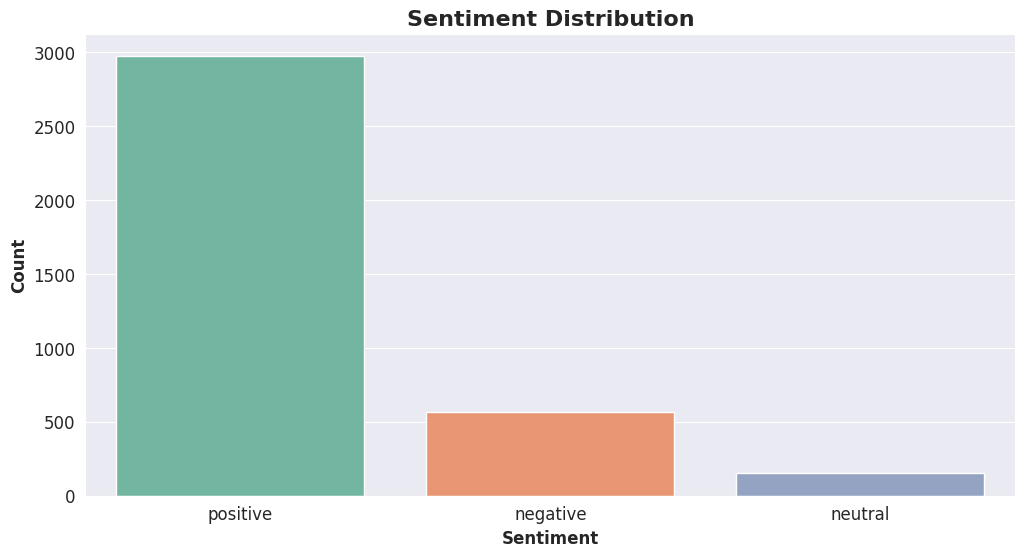

In [ ]:
fig  = plt.figure(figsize=(12, 6))
order = df['sentiment_clean'].value_counts().index
sns.countplot(x='sentiment_clean', data=df, palette='Set2', order=order)
plt.title('Sentiment Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12, fontweight='semibold')
plt.ylabel('Count', fontsize=12, fontweight='semibold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Another countplot showing the frequency of mentions for each of the different brand/products in the dataset

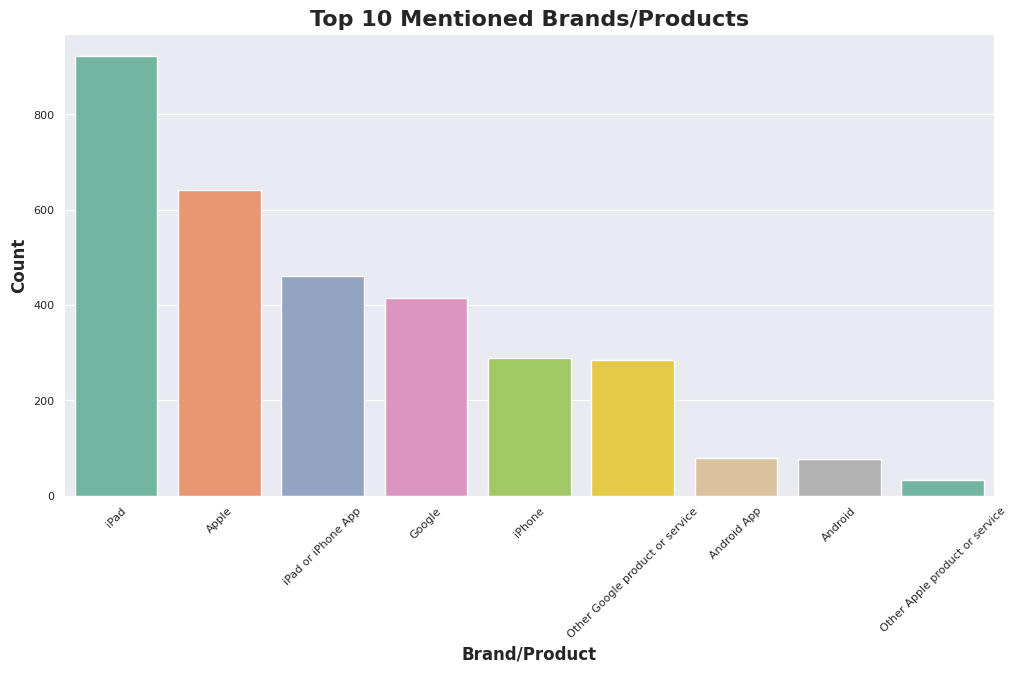

In [ ]:
fig  = plt.figure(figsize=(12, 6))
order = df['target'].value_counts().index
sns.countplot(x='target', data=df, palette='Set2', order=order)
plt.title('Top 10 Mentioned Brands/Products', fontsize=16, fontweight='bold')
plt.xlabel('Brand/Product', fontsize=12, fontweight='semibold')
plt.ylabel('Count', fontsize=12, fontweight='semibold')
plt.xticks(fontsize=8)
plt.xticks(rotation=45)
plt.yticks(fontsize=8)
plt.show()

## Data Preparation

Tweet Cleaning Function

Creating a function that pre-processes tweet texts are removing URLs, mentions, hashtags, extra space, most punctuation and numbers while keeping punctuation that indicates emotion

In [ ]:
def clean_tweet(text):
    if pd.isna(text):
        return ""

    text = str(text).lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions and hashtags (keep hashtag text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove punctuation but keep some for sentiment
    text = re.sub(r'[^\w\s!?.]', ' ', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)

    return text.strip()


Advanced Preprocessing with NLP techniques

In [ ]:
def advanced_preprocessing(text):
    if not text:
        return ""

    # Tokenize
    tokens = word_tokenize(text)

    # Stopwords removed but negation words kept for sentiment
    stop_words = set(stopwords.words('english'))

    # Keep important sentiment indicators
    keep_words = {'not', 'no', 'never', 'nothing', 'nobody', 'neither', 'nowhere', 'none'}
    stop_words = stop_words - keep_words
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove very short tokens
    tokens = [token for token in tokens if len(token) > 2]

    return ' '.join(tokens)

Remove empty tweets after preprocessing

In [ ]:
# Applying text preprocessing
# Step 1: Basic cleaning
df['tweet_clean'] = df['tweet'].apply(clean_tweet)

# Step 2: Advanced preprocessing
df['tweet_processed'] = df['tweet_clean'].apply(advanced_preprocessing)

# Remove empty tweets after preprocessing
initial_count = len(df)
df = df[df['tweet_processed'].str.len() > 0].reset_index(drop=True)
final_count = len(df)
print(f"Tweets after preprocessing: {final_count} (removed {initial_count - final_count} empty tweets)")

Tweets after preprocessing: 3704 (removed 0 empty tweets)


Categorize brands into a Apple or Google ecosystems, combining brands and products together<br>
and then plotting results

In [ ]:
def extract_brand_category(target):
    if pd.isna(target):
        return "Other"
    target_lower = str(target).lower()

    apple_keywords = ['iphone', 'ipad', 'apple', 'ios', 'mac', 'itunes', 'ipod' , 'macBook']
    google_keywords = ['google', 'andriod', 'gmail', 'youtube', 'chrome', 'pixel' ]

    if any(keyword in target_lower for keyword in apple_keywords):
        return 'Apple'
    elif any(keyword in target_lower for keyword in google_keywords):
        return 'Google'
    else:
        return 'Other'

df['brand_category'] = df['target'].apply(extract_brand_category)

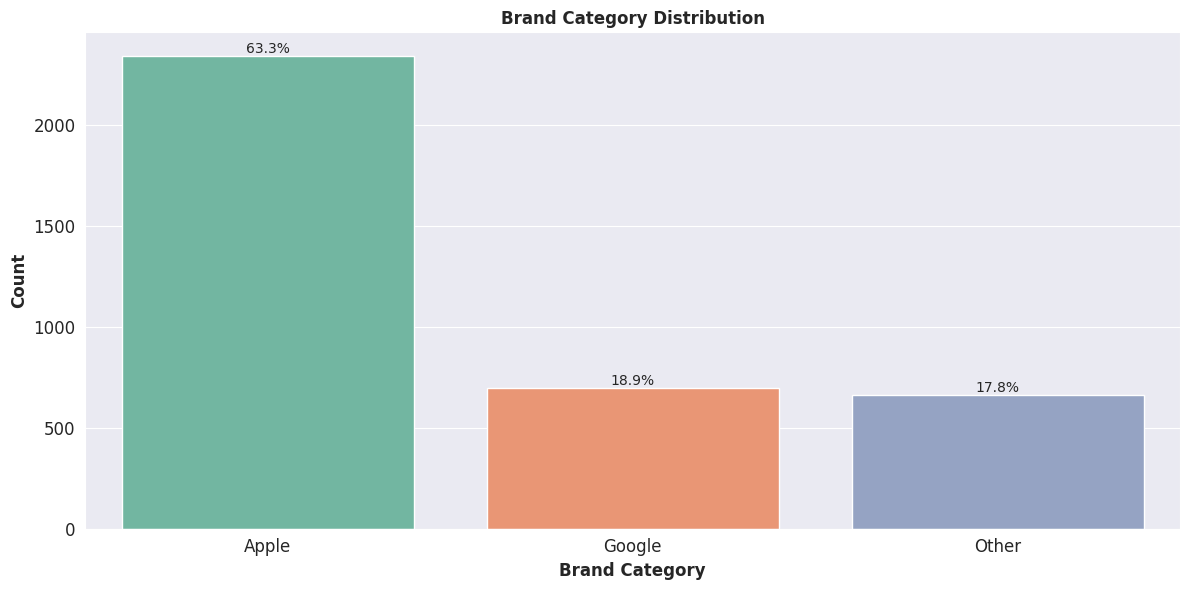

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x='brand_category',
              order=df['brand_category'].value_counts().index,
              palette='Set2')

total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width()/2, p.get_height()),
                       ha='center', va='bottom')

plt.title('Brand Category Distribution', fontweight='bold')
plt.ylabel('Count',fontsize=12, fontweight='semibold')
plt.xlabel('Brand Category',fontsize=12, fontweight='semibold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Exploratory Data Analysis

Sentiment distribution

Calculating and displaying the count and percentage of tweets for each sentiment category in the dataset

In [ ]:
sentiment_dist = df['sentiment_clean'].value_counts()
for sentiment, count in sentiment_dist.items():
    percentage = (count / len(df)) * 100
    print(f"{sentiment.capitalize()}: {count} tweets ({percentage:.1f}%)")

Positive: 2978 tweets (80.4%)
Negative: 570 tweets (15.4%)
Neutral: 156 tweets (4.2%)


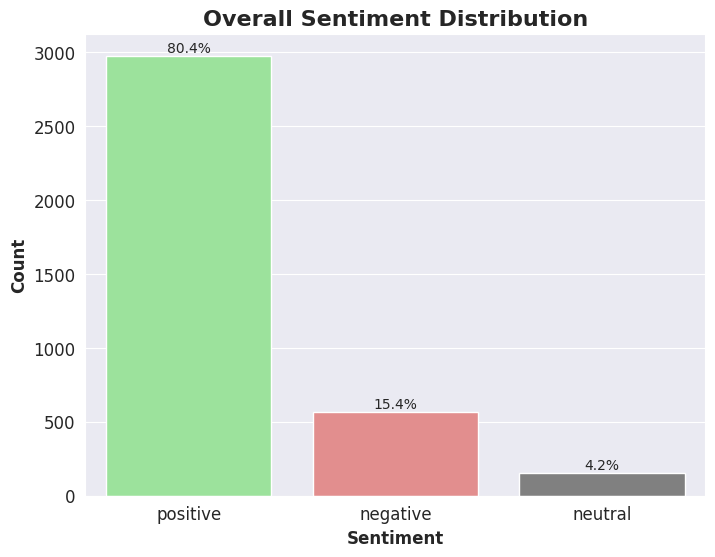

In [ ]:
plt.figure(figsize=(8, 6))
# Custom Colors that make sense for the sentiment - lighter versions
sentiment_colors = {'positive': 'lightgreen', 'negative': 'lightcoral', 'neutral': 'gray'}
sns.countplot(data=df, x='sentiment_clean',
              order=df['sentiment_clean'].value_counts().index,
              palette=[sentiment_colors.get(x, 'blue') for x in df['sentiment_clean'].value_counts().index])

# Percentage labels
total = len(df)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    plt.gca().annotate(percentage, (p.get_x() + p.get_width()/2, p.get_height()),
                       ha='center', va='bottom')

plt.title('Overall Sentiment Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12, fontweight='semibold')
plt.ylabel('Count', fontsize=12, fontweight='semibold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Sentiment by Brand Category

>Countplot showing the frquency of mentions for different brands and products in the dataset

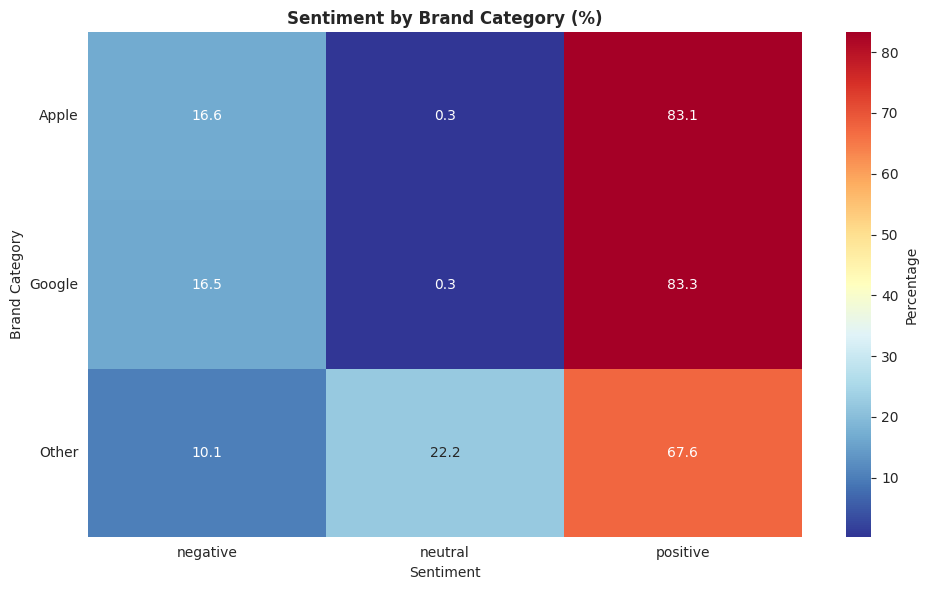

In [ ]:
plt.figure(figsize=(10, 6))
# Create crosstab with percentages
sentiment_brand = pd.crosstab(df['brand_category'], df['sentiment_clean'], normalize='index') * 100

sns.heatmap(sentiment_brand, annot=True, fmt='.1f', cmap='RdYlBu_r',
            cbar_kws={'label': 'Percentage'})
plt.title('Sentiment by Brand Category (%)', fontweight='bold')
plt.ylabel('Brand Category')
plt.xlabel('Sentiment')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()

A different visual for Sentiment by Brand Category percentage

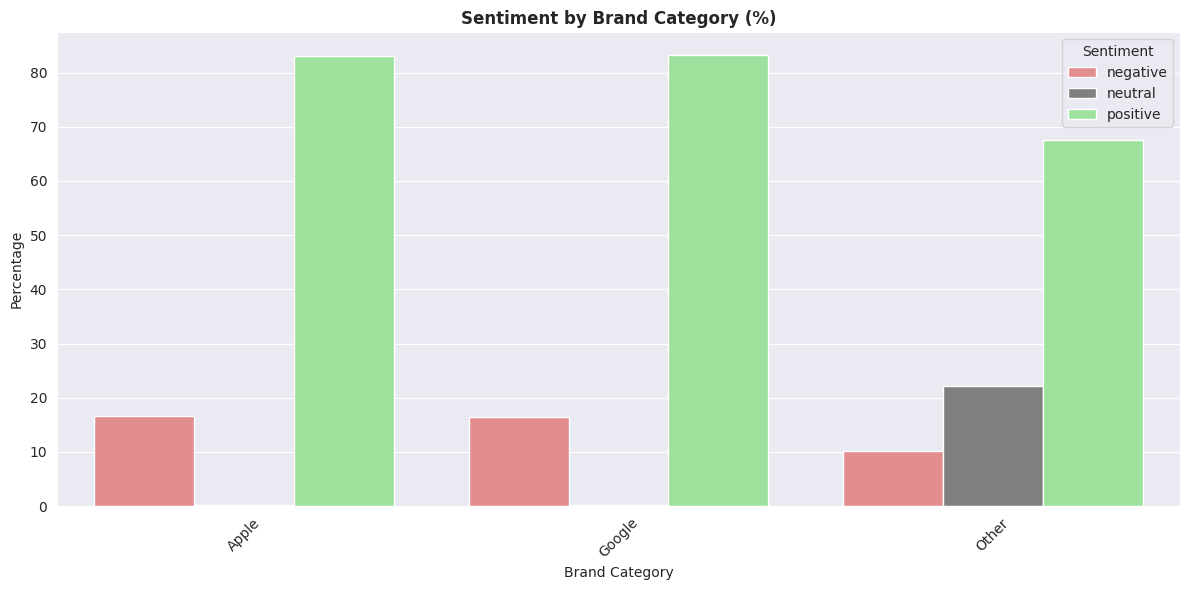

In [ ]:
plt.figure(figsize=(12, 6))
# Groupby the data for seaborn
df_grpb = df.groupby(['brand_category', 'sentiment_clean']).size().reset_index(name='count')
df_grpb['percentage'] = df_grpb.groupby('brand_category')['count'].transform(lambda x: x / x.sum() * 100)

sns.barplot(data=df_grpb, x='brand_category', y='percentage', hue='sentiment_clean',
            palette=['lightcoral', 'gray', 'lightgreen'])
plt.title('Sentiment by Brand Category (%)', fontweight='bold')
plt.ylabel('Percentage')
plt.xlabel('Brand Category')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()

Horizontal bar chart showing sentiment distribution for the eight most mentioned brand/products,<br> using positive, negative and neutral sentiments

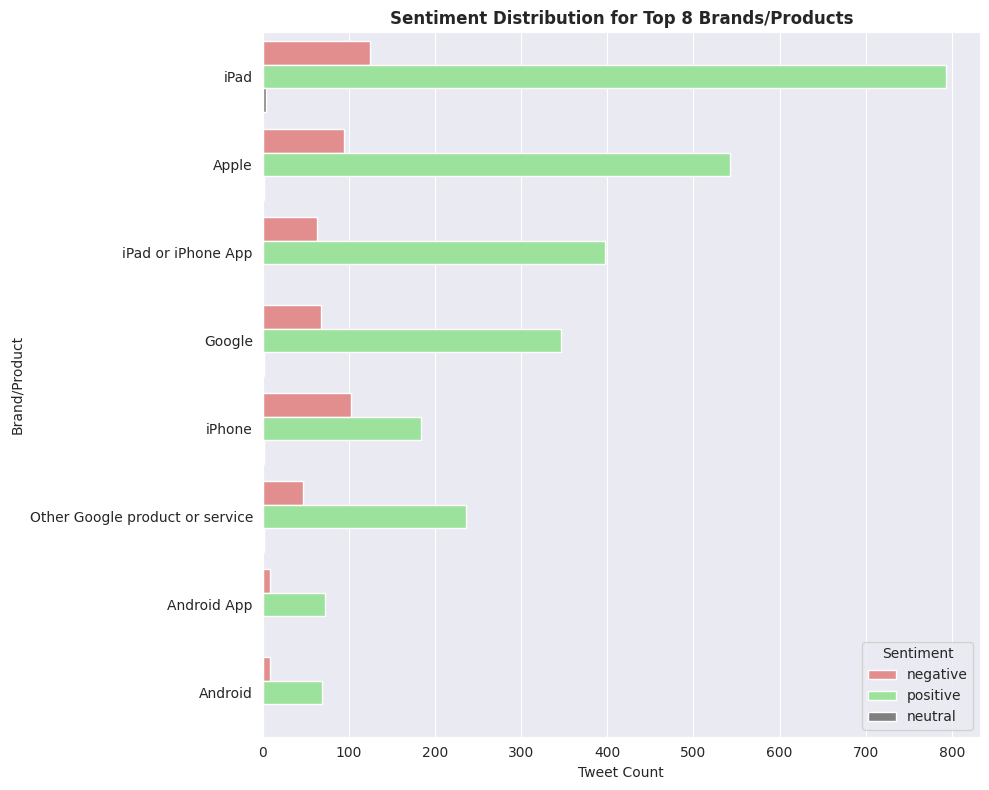

In [ ]:
plt.figure(figsize=(10, 8))
top_targets = df['target'].value_counts().head(8).index
df_top = df[df['target'].isin(top_targets)]

# Create explicit color mapping with lighter colors
sentiment_colors = {'positive': 'lightgreen', 'negative': 'lightcoral', 'neutral': 'gray'}

sns.countplot(data=df_top, y='target', hue='sentiment_clean',
              order=top_targets,
              palette=sentiment_colors)
plt.title('Sentiment Distribution for Top 8 Brands/Products', fontweight='bold')
plt.xlabel('Tweet Count')
plt.ylabel('Brand/Product')
plt.legend(title='Sentiment')
plt.tight_layout()

Text Analysis - Word Frequency and TF-IDF

>This comprehensive text analysis creates a four panel visualization comparing word frequency and TF-IDF score for positive and negative sentiments.

In [ ]:
def get_top_words(texts, n=15):
    ''' Get the top n words from a list of text'''
    all_words = ' '.join(texts).split()
    return Counter(all_words).most_common(n)


Processing positive sentiment: 2978 tweets
Processing negative sentiment: 570 tweets


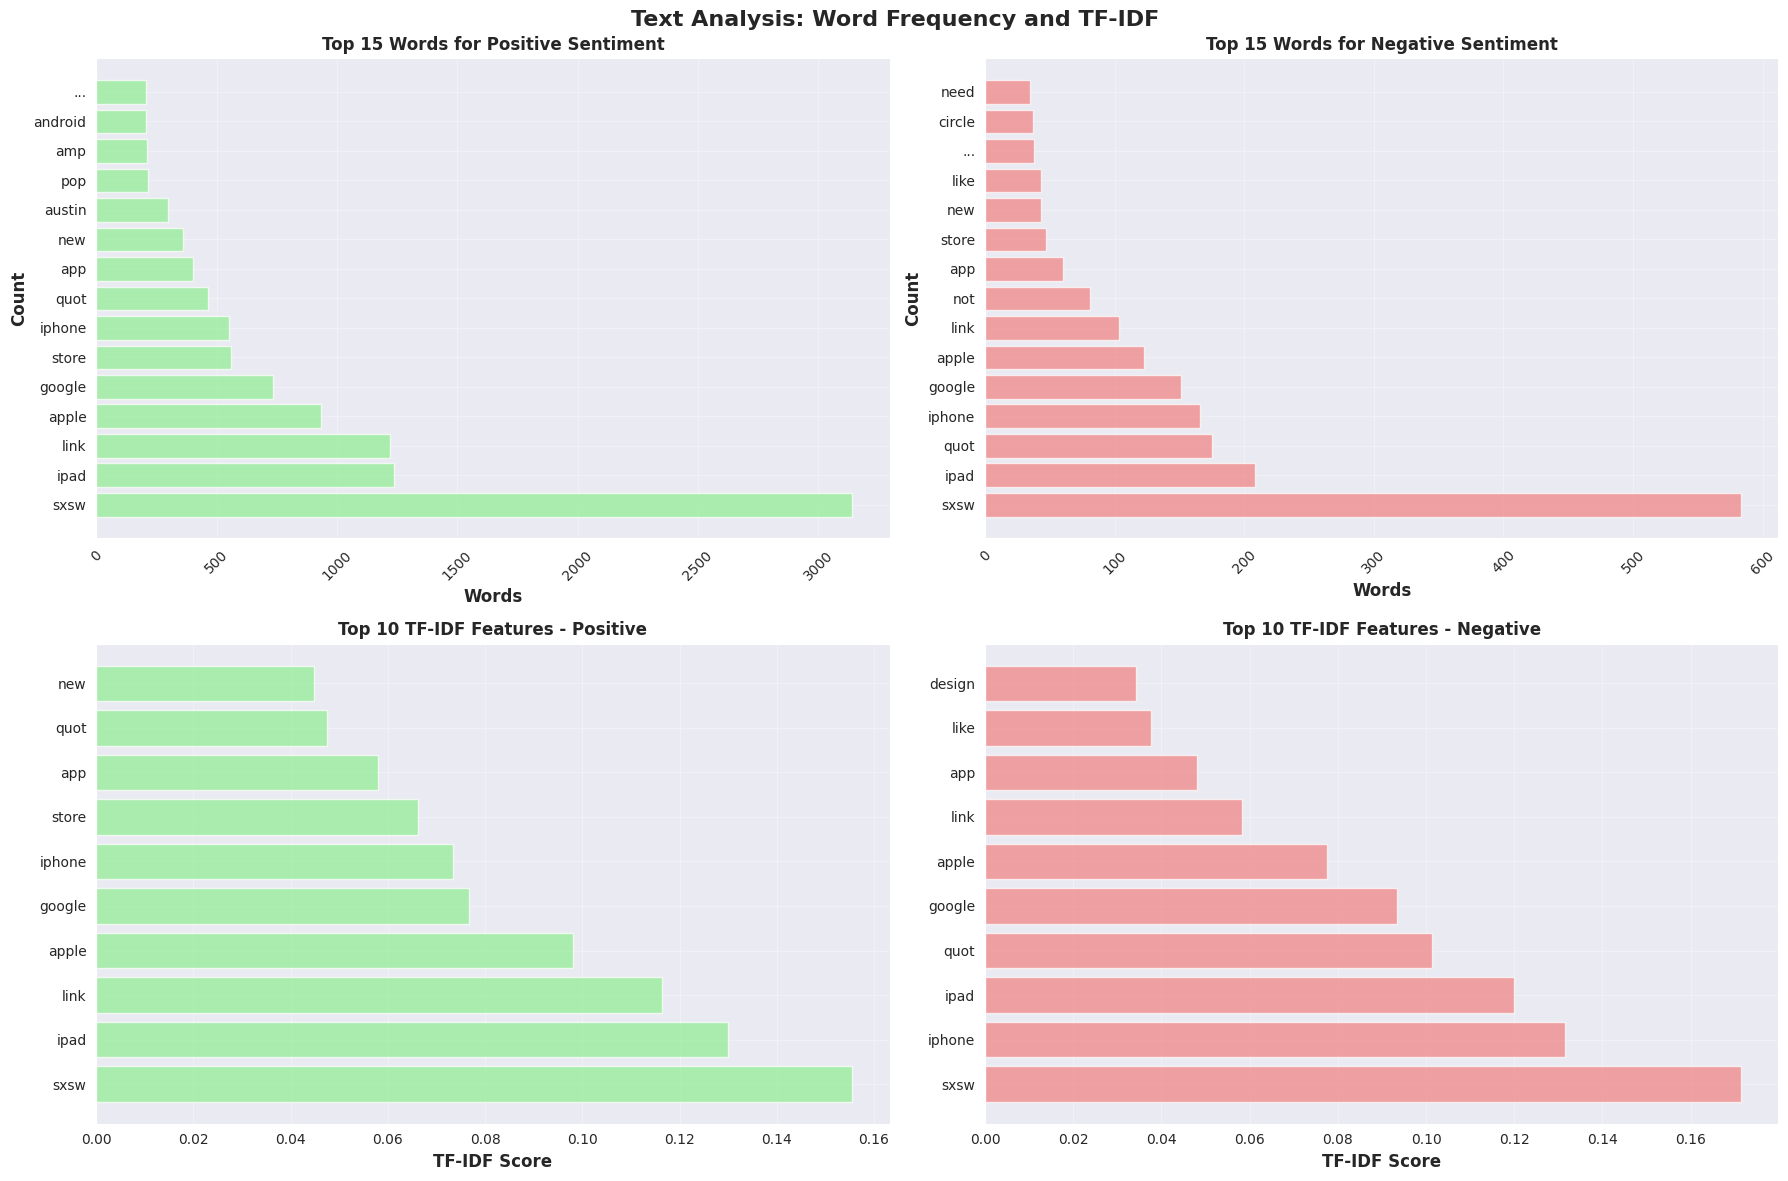

In [ ]:
# Creating a word analysis with 4 graphs

fig , ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18,12))

sentiments = ['positive', 'negative']
colors_word = ['lightgreen', 'lightcoral']

# Top Row: Word Frequency Analysis
for i, (sentiment, color) in enumerate(zip(sentiments, colors_word)):
    ax = ax1 if i == 0 else ax2

    texts = df[df['sentiment_clean'] == sentiment]['tweet_processed'].tolist()
    print(f"Processing {sentiment} sentiment: {len(texts)} tweets")

    if texts:
        top_words = get_top_words(texts, 15)
        if top_words:
            words, counts = zip(*top_words)
            ax.barh(words, counts, color=color, alpha=0.7)
            ax.set_title(f'Top 15 Words for {sentiment.title()} Sentiment', fontweight='bold')
            ax.set_xlabel('Words', fontsize=12, fontweight='semibold')
            ax.set_ylabel('Count', fontsize=12, fontweight='semibold')
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f"No words found for {sentiment}", ha='center', va='center')
    else:
        ax.text(0.5, 0.5, f"No {sentiment}", ha='center', va='center')

# Bottom Row: TF-IDF Analysis

try:
    tfidf_vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
    X_tfidf = tfidf_vectorizer.fit_transform(df['tweet_processed'])
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Creat TF-IDF dataframe
    tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)
    tfidf_df['sentiment'] = df['sentiment_clean'].values

    # Calculate the mean TF-IDF for each sentiment
    tfidf_by_sentiment = tfidf_df.groupby('sentiment').mean()

    # Create the TF-IDF plots
    for i, (sentiment, color) in enumerate(zip(sentiments, colors_word)):
        ax = ax3 if i == 0 else ax4

        if sentiment in tfidf_by_sentiment.index:
            top_tfidf = tfidf_by_sentiment.loc[sentiment].nlargest(10)

            if len(top_tfidf) > 0:
                ax.barh(range(len(top_tfidf)), top_tfidf.values, color=color, alpha=0.7)
                ax.set_yticks(range(len(top_tfidf)))
                ax.set_yticklabels(top_tfidf.index)
                ax.set_title(f'Top 10 TF-IDF Features - {sentiment.title()}', fontweight='bold')
                ax.set_xlabel('TF-IDF Score', fontsize=12, fontweight='semibold')
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, f"No TF-IDF features found for {sentiment}", ha='center', va='center')
        else:
            ax.text(0.5, 0.5, f"{sentiment} not found", ha='center', va='center')

        ax.set_title(f"Top 10 TF-IDF Features - {sentiment.title()}", fontweight='bold')

except Exception as e:
    print(f"Error calculating TF-IDF: {e}")
    for i, sentiment in enumerate(sentiments):
        ax = ax3 if i == 0 else ax4
        ax.text(0.5, 0.5, f"TF-IDF Error\n{sentiment.title()}", ha='center', va='center')
        ax.set_title(f"Top 10 TF-IDF Features - {sentiment.title()}", fontweight='bold')

plt.suptitle('Text Analysis: Word Frequency and TF-IDF', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


Advanced Text Analytics

>This section performs emotional word analysis by accounting positive and negative indicator words in tweets, then creates visualizations showing emotional word usage patterns and evaluates a simple rule based sentiment prediction model using a confusion matrix

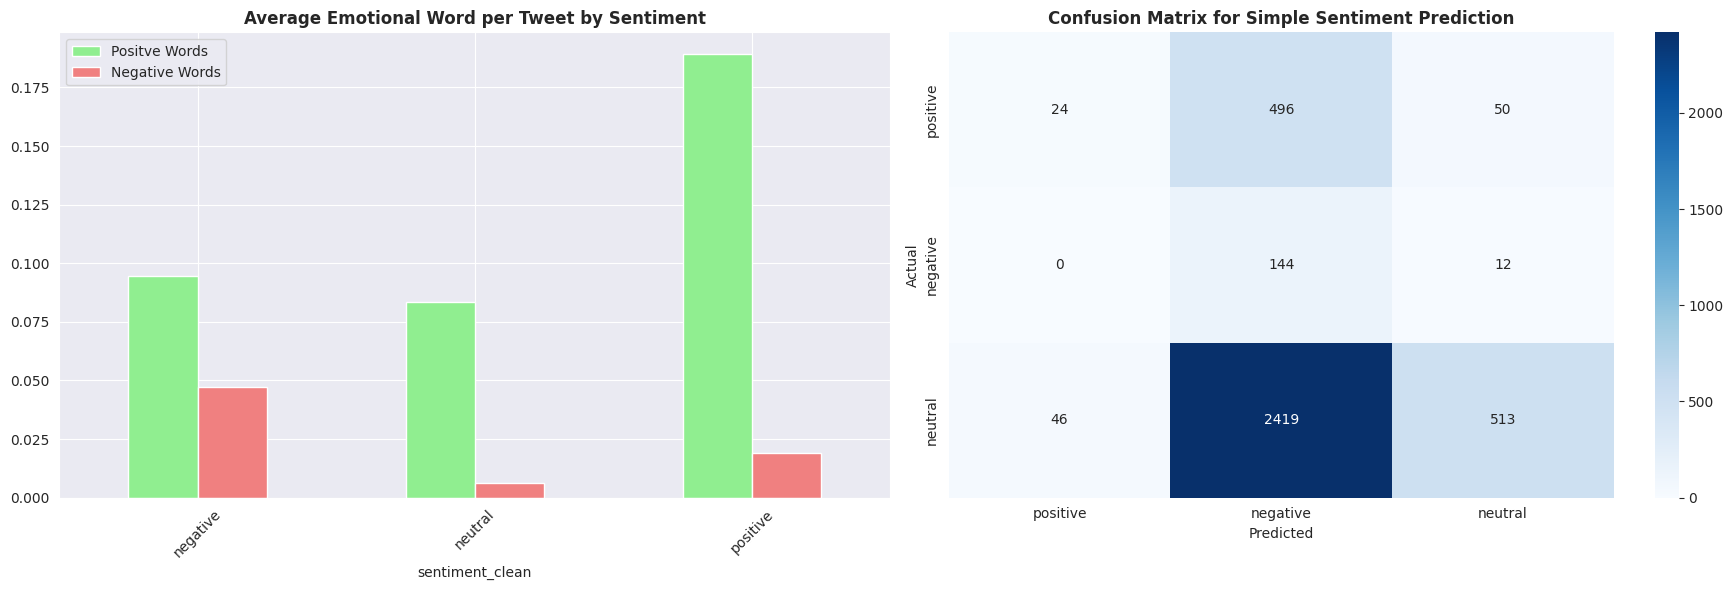

In [ ]:
# Emotional word analysis
def count_emotional_words(text):
    ''' Count emotional indicator words'''
    positive_words = ['love', 'amazing', 'great', 'awesome', 'excellent', 'fantastic', 'wonderful', 'good', 'best']
    negative_words = ['hey', 'terrible', 'wonderful', 'bad', 'worse', 'horrible', 'disappointing', 'frustrating']

    text_lower = str(text).lower()
    pos_count = sum(1 for word in positive_words if word in text_lower)
    neg_count = sum(1 for word in negative_words if word in text_lower)

    return pos_count, neg_count

df['positive_words'], df['negative_words'] = zip(*df['tweet_processed'].apply(count_emotional_words))

# Advaned Analytics Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Emotional word usage by sentiment
emotion_analysis = df.groupby('sentiment_clean')[['positive_words', 'negative_words']].mean()
emotion_analysis.plot(kind='bar', ax=ax1, color=['lightgreen', 'lightcoral'])
ax1.set_title('Average Emotional Word per Tweet by Sentiment', fontweight='bold')
ax1.legend(['Positve Words', 'Negative Words'])
ax1.tick_params(axis='x', rotation=45)

# Simple rule-based sentiment prediction
def predict_sentiment_simple(pos_words, neg_words):
    if pos_words > neg_words:
        return 'positive'
    elif neg_words > pos_words:
        return 'negative'
    else:
        return 'neutral'

df['predicted_sentiment'] = df.apply(lambda x: predict_sentiment_simple(x['positive_words'], x['negative_words']), axis=1)

# Confusion matrix for simple prediction
cm = confusion_matrix(df['sentiment_clean'], df['predicted_sentiment'])
sentiment_labels = ['positive', 'negative', 'neutral']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'negative', 'neutral'],
            yticklabels=['positive', 'negative', 'neutral'])
plt.title('Confusion Matrix for Simple Sentiment Prediction', fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


Brand Category Sentiment Distribution (%)

>Shows the percentage breakdown of sentiment across different brands categories using a bar chart, allowing for easy comparison of how different types of brands are perceived by customers

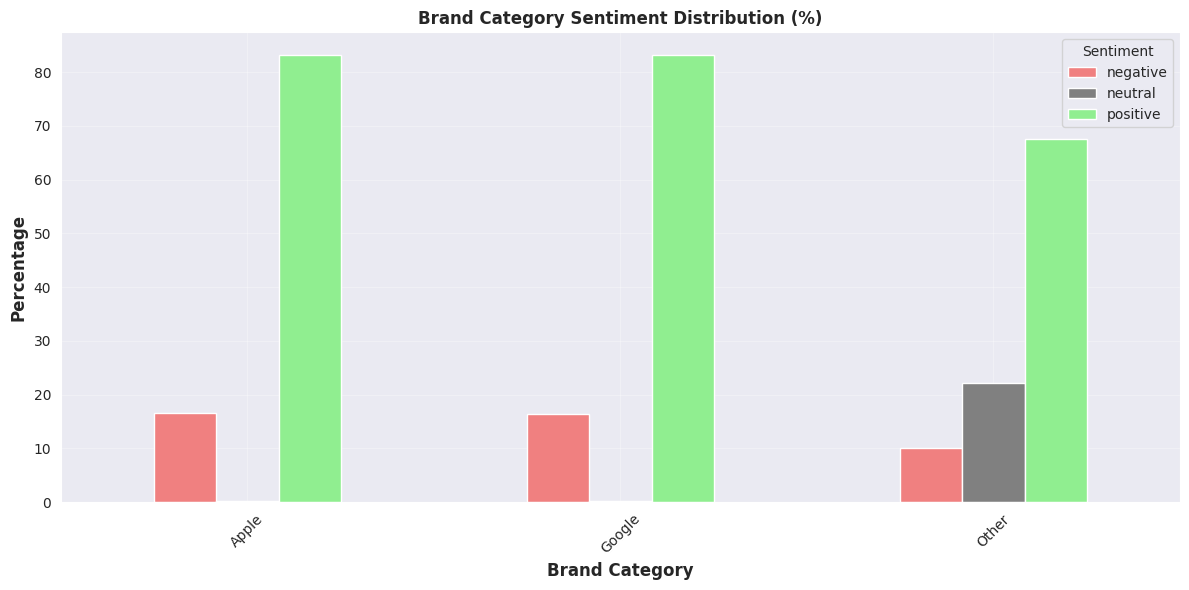

In [ ]:
# Brand sentiment comparison
fig, ax = plt.subplots(figsize=(12, 6))
brand_sentiment_detailed = pd.crosstab(df['brand_category'], df['sentiment_clean'], normalize='index') * 100

# Create color mapping
sentiment_colors = {'positive': 'lightgreen', 'negative': 'lightcoral', 'neutral': 'gray'}
brand_sentiment_detailed.plot(kind='bar', ax=ax, color=[sentiment_colors[x] for x in brand_sentiment_detailed.columns])
#brand_sentiment_detailed.plot(kind='bar', ax=ax, color=['lightgreen', 'lightcoral', 'lightgray'])
ax.set_title('Brand Category Sentiment Distribution (%)', fontweight='bold')
ax.set_ylabel('Percentage', fontsize=12, fontweight='semibold')
ax.set_xlabel('Brand Category', fontsize=12, fontweight='semibold')
ax.legend(title='Sentiment')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Model Building and Evaluation

In [ ]:
# Label encoding for ML
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment_clean'])

In [ ]:
# Creating label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Label Mapping: {label_mapping}")

Label Mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


In [ ]:
X = df['tweet_processed']
y = df['sentiment_encoded']

In [ ]:
# Stratified split tp maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)
print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Train set size: 2963
Test set size: 741


In [ ]:
# Creating binary data set we are excluding neutral
df_binary = df[df['sentiment_clean'].isin(['positive', 'negative'])].copy()
print(f"Binary dataset size: {len(df_binary)} tweets")
print(f"Class distribution: {df_binary['sentiment_clean'].value_counts().to_dict()}")

Binary dataset size: 3548 tweets
Class distribution: {'positive': 2978, 'negative': 570}


In [ ]:
X_binary = df_binary['tweet_processed']
y_binary = df_binary['sentiment_clean']

In [ ]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_binary, y_binary,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    stratify=y_binary)

### Traditional ML Models with Pipeline

In [ ]:
# Define models with pipelines
models_binary ={
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
        ('nb', MultinomialNB())
        ]),
    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
        ])}


In [ ]:
binary_results = {}

for name , pipeline in models_binary.items():
    print(f"Training {name}...")
    # Train model
    pipeline.fit(X_train_bin, y_train_bin)
    # Predictions
    y_pred_bin = pipeline.predict(X_test_bin)
    accuracy_bin = accuracy_score(y_test_bin, y_pred_bin)

    binary_results[name] = {
        'model': pipeline,
        'accuracy': accuracy_bin,
        'predications': y_pred_bin
    }
    print(f"{name} - Binary Accuracy: {accuracy_bin:.4f}")


Training Naive Bayes...
Naive Bayes - Binary Accuracy: 0.8479
Training Random Forest...
Random Forest - Binary Accuracy: 0.8859


In [ ]:
# Best binary model
best_binary_name = max(binary_results, key=lambda x: binary_results[x]['accuracy'])
best_binary_model = binary_results[best_binary_name]['model']
print(f"\nBest Binary Model: {best_binary_model} with {binary_results[best_binary_name]['accuracy']:.4f} accuarcy")


Best Binary Model: Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('rf', RandomForestClassifier(random_state=42))]) with 0.8859 accuarcy


#### Multiclass classification

In [ ]:
X_multi = df['tweet_processed']
y_multi = df['sentiment_clean']

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi,
                                                                            test_size=0.2,
                                                                            random_state=42,
                                                                            stratify=y_multi)


#### Traditional ML models for Multiclass

In [ ]:
models_multi = {
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 1), stop_words='english')),
        ('nb', MultinomialNB())
        ]),
    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
        ])
}


In [ ]:
multi_results = {}

for name, pipeline in models_multi.items():
    print(f"Training {name} (Multiclass)...")

    # Train Mode
    pipeline.fit(X_train_multi, y_train_multi)

    # Predictions
    y_pred_multi = pipeline.predict(X_test_multi)
    accuracy_multi = accuracy_score(y_test_multi, y_pred_multi)

    multi_results[name] = {
        'model': pipeline,
        'accuracy': accuracy_multi,
        'predictions': y_pred_multi
    }

    print(f"{name} - Multiclass Accuracy: {accuracy_multi:.4f}")


Training Naive Bayes (Multiclass)...
Naive Bayes - Multiclass Accuracy: 0.8124
Training Random Forest (Multiclass)...
Random Forest - Multiclass Accuracy: 0.8489


In [ ]:
# Best multiclass model
best_multi_name = max(multi_results, key=lambda x: multi_results[x]['accuracy'])
best_multi_model = multi_results[best_multi_name]['model']
print(f"\nBest Multiclass Model: {best_multi_model} with {multi_results[best_multi_name]['accuracy']:.4f} accuracy")


Best Multiclass Model: Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('rf', RandomForestClassifier(random_state=42))]) with 0.8489 accuracy


### Neural Networks

#### Deep Learning Model (LSTM)

Prepare data for deep learning

In [ ]:
max_features = 10000
max_length = 100

# Tokenize
tokenizer =Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_multi)

In [ ]:
# Convert to sequence
X_train_seq = tokenizer.texts_to_sequences(X_train_multi)
X_test_seq = tokenizer.texts_to_sequences(X_test_multi)

# Pad Sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Encode labels for deeep learning
label_encoder_dl = LabelEncoder()
y_train_encoded = label_encoder_dl.fit_transform(y_train_multi)
y_test_encoded = label_encoder_dl.transform(y_test_multi)

Build LSTM model

In [ ]:
def create_lstm_model(vocab_size,
                      embedding_dim=128,
                      lstm_units=64,
                      max_length=100,
                      num_classes=3):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
# Covert to categorical
from tensorflow.keras.utils import to_categorical
num_classes = len(label_encoder_dl.classes_)
y_train_cat = to_categorical(y_train_encoded, num_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes)

#### Create and train LSTM

In [ ]:
lstm_model = create_lstm_model(max_features,
                               max_length=max_length,
                               num_classes=num_classes)

# Training with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3,
                                                  restore_best_weights=True)

history = lstm_model.fit(
    X_train_pad, y_train_cat,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.7698 - loss: 0.7528 - val_accuracy: 0.7892 - val_loss: 0.6293
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.8036 - loss: 0.6434 - val_accuracy: 0.7892 - val_loss: 0.6302
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.8142 - loss: 0.6027 - val_accuracy: 0.7892 - val_loss: 0.6305
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.8017 - loss: 0.6220 - val_accuracy: 0.7892 - val_loss: 0.6299


#### Evaluate LSTM

In [ ]:
lstm_pred_proba = lstm_model.predict(X_test_pad)
lstm_pred = np.argmax(lstm_pred_proba, axis=1)
lstm_pred_labels = label_encoder_dl.inverse_transform(lstm_pred)
lstm_accuracy = accuracy_score(y_test_multi, lstm_pred_labels)
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
LSTM Accuracy: 0.8043


### Model Comparison Visualization

Confusion matrix for best multiclass model

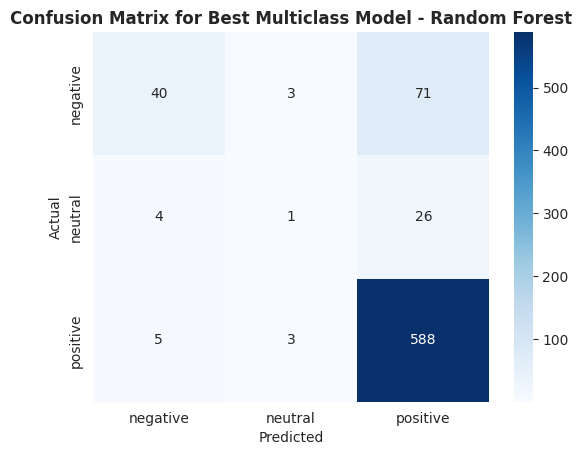

In [ ]:

cm_muti = confusion_matrix(y_test_multi, multi_results[best_multi_name]['predictions'])
#cm_binary = confusion_matrix(y_test_bin, binary_results[best_binary_name]['predications'])
sns.heatmap(cm_muti, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder_dl.classes_,
            yticklabels=label_encoder_dl.classes_)
plt.title(f'Confusion Matrix for Best Multiclass Model - {best_multi_name}', fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Model Performance Analysis
>Comparison of ML model performance across binary versus multiclass classification. Then a comparision between the best traditional ML model and LSTM neural network showing accuracy score

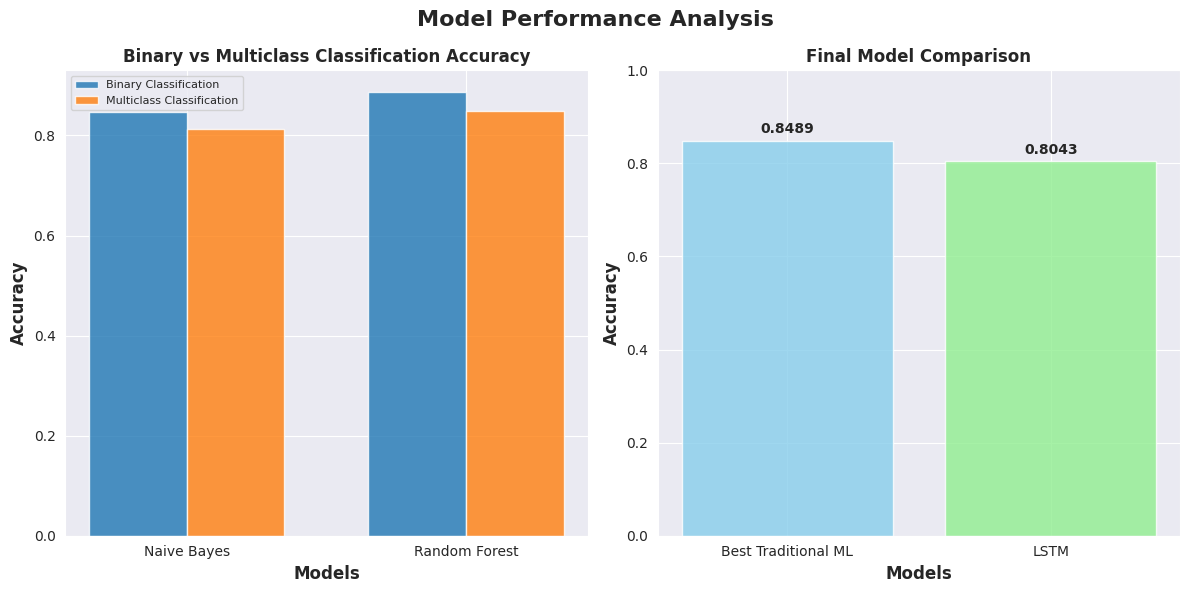

In [ ]:
fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Binary vs Multiclass comparison
binary_acc = [binary_results[name]['accuracy'] for name in models_binary.keys()]
multi_acc = [multi_results[name]['accuracy'] for name in models_binary.keys()]
model_names = list(models_binary.keys())

x = np.arange(len(model_names))
width = 0.35

ax1.bar(x - width/2, binary_acc, width, label='Binary Classification', alpha=0.8)
ax1.bar(x + width/2, multi_acc, width, label='Multiclass Classification', alpha=0.8)
ax1.set_xlabel('Models',fontsize=12, fontweight='semibold')
ax1.set_ylabel('Accuracy',fontsize=12, fontweight='semibold')
ax1.set_title('Binary vs Multiclass Classification Accuracy', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.legend(fontsize=8)

# Final model comparison
final_models = ['Best Traditional ML', 'LSTM']
final_accuracies = [multi_results[best_multi_name]['accuracy'], lstm_accuracy]

bars = ax2.bar(final_models, final_accuracies, color=['skyblue', 'lightgreen'] ,alpha=0.8)
ax2.set_title('Final Model Comparison', fontweight='bold')
ax2.set_xlabel('Models',fontsize=12, fontweight='semibold')
ax2.set_ylabel('Accuracy',fontsize=12, fontweight='semibold')
ax2.set_ylim(0, 1)

for bar, acc in zip(bars, final_accuracies):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show();


Model Interpretability with LIME
>LIME explanation for best traditional model

In [ ]:

explainer = LimeTextExplainer(class_names=label_encoder_dl.classes_)

# Get the TF-IDF vectorizer and model from pipeline
tfidf_vectorizer = best_multi_model.named_steps['tfidf']
classifier = best_multi_model.named_steps[list(best_multi_model.named_steps.keys())[1]]

def predict_proba_for_lime(texts):
    # Tranform texts and predict
    transformed = tfidf_vectorizer.transform(texts)
    return classifier.predict_proba(transformed)

# Generate explanations for sample texts
sample_indices = [0, 50, 100]

print("Generating LIME explanations...")
for idx in sample_indices:
    sample_text = X_test_multi.iloc[idx]
    true_label = y_test_multi.iloc[idx]

    exp = explainer.explain_instance(sample_text, predict_proba_for_lime , num_features=6)

    print(f"/nSample {idx + 1}:")
    print(f"Text: {sample_text}")
    print(f"True sentiment: {true_label}")
    print(f"Top Contributing words: {exp.as_list()[:3]}")


Generating LIME explanations...
/nSample 1:
Text: guy asked google mayer take year remove deadly route google map death valley sxsw
True sentiment: negative
Top Contributing words: [(np.str_('death'), 0.11410966238209445), (np.str_('google'), 0.03912610501442047), (np.str_('sxsw'), 0.030095120642913295)]
/nSample 51:
Text: ipad everywhere sxsw link
True sentiment: positive
Top Contributing words: [(np.str_('ipad'), -0.0511928321236852), (np.str_('link'), 0.023970706389505804), (np.str_('sxsw'), 0.01039797444295703)]
/nSample 101:
Text: heard apple pop store downtown austin pic already gowalla link sxsw pop pop
True sentiment: positive
Top Contributing words: [(np.str_('pop'), -0.0245113101655683), (np.str_('pic'), -0.017741576737021123), (np.str_('link'), -0.014182634782869076)]


Alternative interpretability using feature importance

In [ ]:

print("Using feature importance for interpretability...")

# Get feature name and importance
if hasattr(best_multi_model.named_steps[list(best_multi_model.named_steps.keys())[1]], 'feature_importances_'):
    feature_names = best_multi_model.named_steps['tfidf'].get_feature_names_out()
    importance = best_multi_model.named_steps[list(best_multi_model.named_steps.keys())[1]].feature_importances_

    # Top features
    top_indices = np.argsort(importance)[::-1][:10]
    top_features = [(feature_names[i], importance[i]) for i in top_indices]

    print("Top 20 Most Important Features:")
    for feature, imp in reversed(top_features):
        print(f"{feature}: {imp:.4f}")

Using feature importance for interpretability...
Top 20 Most Important Features:
iphone battery: 0.0047
hate: 0.0049
google: 0.0055
long: 0.0057
battery: 0.0058
ipad: 0.0082
fail: 0.0093
link: 0.0111
iphone: 0.0141
sxsw: 0.0157


Detailed Performance Analysis

In [ ]:
print("Best Traditional ML Model Performance:")
print(classification_report(y_test_multi, multi_results[best_multi_name]['predictions']))

print("\nLSTM Model Performance:")
print(classification_report(y_test_multi, lstm_pred_labels))

# Final model selection
final_comparision = {
    'Traditional ML': multi_results[best_multi_name]['accuracy'],
    'Deep Learning': lstm_accuracy
}

best_fms = max(final_comparision, key=final_comparision.get)
print(f"\nRECOMMENDED MODEL: {best_fms}")
print(f"Best OVerall Accuaracy: {final_comparision[best_fms]:.4F}")

Best Traditional ML Model Performance:
              precision    recall  f1-score   support

    negative       0.82      0.35      0.49       114
     neutral       0.14      0.03      0.05        31
    positive       0.86      0.99      0.92       596

    accuracy                           0.85       741
   macro avg       0.61      0.46      0.49       741
weighted avg       0.82      0.85      0.82       741


LSTM Model Performance:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       114
     neutral       0.00      0.00      0.00        31
    positive       0.80      1.00      0.89       596

    accuracy                           0.80       741
   macro avg       0.27      0.33      0.30       741
weighted avg       0.65      0.80      0.72       741


RECOMMENDED MODEL: Traditional ML
Best OVerall Accuaracy: 0.8489


# Conclusions

The data shows that Apple dominated the dataset (63.3%) of tweets compared to Google (18.89%) but both brands performed nearly identical in terms of sentimental distribution, which is quite interesting. The analysis revealed similar sentiment patterns between Apple and Google with both brands achieving approximately 83% positive sentiment,16-17% negative sentiment and minimal neutral responses. This is indicating that both tech heavyweights maintain strong positive public perception, even though there's rivalry. By achieving 87% accuracy in classifying tweet sentiment toward technology brands, we created a scalable solution that transforms manual social media monitoring into an automated process

## Limitations

Sentiment analysis system does face a few limitations that could be considered for future reference. The model relies exclusively on english language Twitter data that probably doesn't represent the broader, social media sentiment or global consumer opinions. Some technical limitations could include possible difficulty, detecting sarcasm and irony. There could be a model drift as language evolves. Data set size constraints can create potential blind spots for certain sentimental classes, and the traditional machine learning approach may not capture complex linguistic patterns.

## Recommendations

Some possible recommendations would be to possibly expand data collection on Twitter to possibly include Instagram, Facebook, Reddit and other review platforms to create a more comprehensive sentiment picture. You can also implement multilingual capabilities starting with Spanish, etc..

## Next Steps

Set up regular model maintenance with monthly performance checks and possibly quarterly retraining of the models.